## Import Packages

In [3]:
#import csv, pprint, json, base64, 
import zlib, struct
import matplotlib.pyplot as plt
%matplotlib inline

## Relevant Docs

#### [Relevant Python Documentation for Reading C Structs into Python](https://docs.python.org/3.5/library/struct.html "Python Docs for C Structs")

#### [Excellent code snippets for working with Binary data in Python](https://www.devdungeon.com/content/working-binary-data-python "DevDungeon")

|doc | url |
|-----|-----|
| adiBin docs| http://cdn.adinstruments.com/adi-web/manuals/translatebinary/LabChartBinaryFormat.pdf |
| adiBin header|  http://cdn.adinstruments.com/adi-web/manuals/translatebinary/ADIBinaryFormat.h |
| adiBin example|http://cdn.adinstruments.com/adi-web/manuals/translatebinary/TranslateBinary.c |
|source | https://forum.adinstruments.com/viewtopic.php?t=395 |

## Check Global Variables

In [4]:
# Global Variables for ADIBIN file structure
HEADER_LENGTH = 68
CHANNEL_TITLE_LENGTH = 96

# Format Strings to parse C Structs in Python
# ADIBinaryFormat.h dictates little endian format - leading '<' in format string
# s = multiple char as one, l = long, d = double
# 4s = 4 char are first item, read in as one, followed by one long, one double, etc.
# 32s = 32 char, read in as first and second item, followed by 4 doubles, read in each separately
ADI_FILE_HEADER_FORMAT_STRING = "<4sldlllllddllll"
sizeHeader=struct.calcsize(ADI_FILE_HEADER_FORMAT_STRING)

ADI_CHANNEL_TITLE_FORMAT_STRING = "<32s32sdddd"
sizeChannel=struct.calcsize(ADI_CHANNEL_TITLE_FORMAT_STRING)


# Sanity Check - Make sure format string templates length match global variables for lengths
# Lengths specified in ADIBinaryFormat.h file - documentation on adibin files
# File Header is 68 bytes and Channel Titles are 96 bytes
if (sizeHeader == HEADER_LENGTH):
    print('Headers Match :)')
else:
    print('Headers Mismatch :(')

if (sizeChannel == CHANNEL_TITLE_LENGTH):
    print('Channel Titles Match :)')
else:
    print('Channel Titles Mismatch :(')
    
    #print(sizeHeader, sizeChannel)

Headers Match :)
Channel Titles Match :)


## Parse ADIBIN Function

In [12]:
# param adibin_file: output of 'open' command in python3 (like _io.BufferedReader)
def parseChannels(adibin_file, dbg=False):
    FILE_HEADER_LENGTH = 68
    CHANNEL_HEADER_LENGTH = 96

    ADI_FILE_HEADER_FORMAT_STRING = "<4sldlllllddllll"
    ADI_CHANNEL_HEADER_FORMAT_STRING = "<32s32sdddd"

    # Start at the beginning of the buffer
    adibin_file.seek(0)
    
    # Read in overall file header
    file_header_bytes = adibin_file.read(FILE_HEADER_LENGTH)
    
    # Parse overall file header according to format string
    magic, version, secs_per_tick, year, month, day, hour, minute, second, \
     trigger, num_channels, samples_per_channel, time_channel, data_format \
    = struct.unpack(ADI_FILE_HEADER_FORMAT_STRING, file_header_bytes)
    
    # Check data visually
    if dbg == True:
        print("Magic:", magic.decode('utf-8'))
        print("Version:", version)
        print("secsPerTick:", secs_per_tick)
        print("Year:", year)
        print("Month:", month)
        print("Day:", day)
        print("Hour:", hour)
        print("Minute:", minute)
        print("Second:", second)
        print("Trigger:", trigger)
        print("NChannels:", num_channels)
        print("SamplesPerChannel:", samples_per_channel)
        print("TimeFormat:", time_channel)
        print("DataFormat:", data_format)
        print('---')
    
    #Figure out length of rest of the file by checking DataFormat and SamplesPerChannel
    #DataFormat 1=double, 2=float, 3=16-bit integer
    #sizeof(double) = 8 bytes, sizeof(float) = 4 bytes, sizeof(16-bit integer) = 2 bytes 
    if (data_format == 1): # 8 byte double
        bytes_per_sample = 8
        sample_format_string = 'd'
    elif (data_format == 2): # 4 byte float
        bytes_per_sample = 4
        sample_format_string = 'f'
    elif (data_format == 3): # 2 byte int
        bytes_per_sample = 2
        sample_format_string = 'h'
    else:
        return ValueError('DataFormat Not Coded to 1,2,or 3')
    
    # Order of entries in the array:
    data_names = ['ChannelIndex', 'ChannelTitle', 'Units', 'Scale', 
                            'Offset', 'RangeHigh', 'RangeLow', 'ChannelData']
    data_values_list = []

    # For every channel, read the header
    for channel_num in range(0, num_channels):
        channel_title_buffer = adibin_file.read(CHANNEL_HEADER_LENGTH)
        
        # Parse Channel Title Fields
        channel_title, units, scale, offset, range_high, range_low \
        = struct.unpack(ADI_CHANNEL_HEADER_FORMAT_STRING, channel_title_buffer)
        
        # Sanity Check
        if dbg == True:
            print("ChannelTitle:", channel_title.decode('utf-8'))
            print("UnitsBin:", units)
            print("Units:", units.decode('utf-8'))
            print("Scale:", scale)
            print("offset:", offset)
            print("RangeHigh:", range_high)
            print("RangeLow:", range_low)
            print('---')

        # Append channel title fields to array
        data_values_list.append([channel_num,
                                 channel_title.decode('utf-8').rstrip('\0'), 
                                 units.decode('utf-8').rstrip('\0'), 
                                 scale, 
                                 offset, 
                                 range_high, 
                                 range_low,
                                 []])

    # For every signal sample
    for sample in range(0, samples_per_channel):
        # For every channel
        for channel in range(0, num_channels):           
            data_values_list[channel][7].append(struct.unpack(sample_format_string,
                                                              adibin_file.read(bytes_per_sample))[0])
    
    # Return Parsed Array
    return list(map(lambda x: dict(zip(data_names, x)), data_values_list))

## Examples

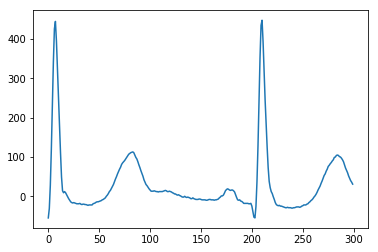

In [13]:
adibinFilename = "./sampleFiles/example.adibin"

with open(adibinFilename, "rb") as adibin_file:
    ecg_channel_data = parseChannels(adibin_file, dbg=False)

plt.plot(ecg_channel_data[0]['ChannelData'][0:300])

# Sanity Checks

In [14]:
with open(adibinFilename, "rb") as adibin_file:
    ecg_channel_data = parseChannels(adibin_file, dbg=True)

Magic: CFWB
Version: 1
secsPerTick: 0.004166666666666667
Year: 2016
Month: 10
Day: 29
Hour: 9
Minute: 47
Second: 0.0
Trigger: 0.0
NChannels: 10
SamplesPerChannel: 7201
TimeFormat: 0
DataFormat: 3
---
ChannelTitle: I                               
UnitsBin: b'mV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
Units: mV                              
Scale: 2.44
offset: 0.0
RangeHigh: 1.0
RangeLow: 0.0
---
ChannelTitle: II                              
UnitsBin: b'mV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
Units: mV                              
Scale: 2.44
offset: 0.0
RangeHigh: 1.0
RangeLow: 0.0
---
ChannelTitle: III                             
UnitsBin: b'mV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
Units: mV                              
Scale: 2.44
offse

In [7]:
# period from frequency conversion - data @ 240 hz.
print(1/240)

0.004166666666666667


In [ ]:
with open(adibinFilename, "rb") as adibin_file:
    #Parse adibin File
    adibin_file.seek(0, 2)  # Seek the end
    num_bytes = adibin_file.tell()  # Get the file size
    print(num_bytes)

In [ ]:
# Number of bytes accounted for by file header and channel headers
68+10*96

In [ ]:
# Number of bytes left to be accounted for by channel data
145048-1028

In [ ]:
#samples per channel * bytes per sample * number of channels
7201*2*10

In [ ]:
#samples per channel = 7201
#10 channels
#where data = scale * (sample + offset)
#dataformat = 3 so 16 bit format = 2 bytes per sample
guess=(2.44*7*(7201*2 + 0)) + (.2*(7201*2 + 0)) + (1*(7201*2 + 0)) + (.1*(7201*2 + 0))
print(guess)

In [ ]:
with open(adibinFilename, "rb") as binary_file:
    data = binary_file.read()
    
    binary_file.seek(0)
    magic = binary_file.read(4)
    print(magic)

In [ ]:
with open(adibinFilename, "rb") as binary_file:
    data = binary_file.read()
    
    binary_file.seek(0)
    magic = binary_file.read(4)
    version = binary_file.read(4)
    intVersion = int.from_bytes(version, byteorder='little')
    secsPerTick = binary_file.read(8)
    intSecsPerTick = int.from_bytes(secsPerTick, byteorder='little')
    print(magic, version, intVersion, secsPerTick, intSecsPerTick)
    